In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import uniform, randint, loguniform
from sklearn.ensemble import VotingClassifier

In [18]:
df_train = pd.read_csv("P:/notebooks/competition KAGGLE/data/Diabetes Prediction Challenge/train.csv")
df_test = pd.read_csv("P:/notebooks/competition KAGGLE/data/Diabetes Prediction Challenge/test.csv")

In [19]:
df_train.isna().sum()

id                                    0
age                                   0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
smoking_status                        0
employment_status                     0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0


In [20]:
target = df_train["diagnosed_diabetes"]
idk = df_test["id"]
df_train = df_train.drop(columns=["diagnosed_diabetes", "id"])
df_test = df_test.drop(columns=["id"])

In [21]:
df_train.columns.tolist()

['age',
 'alcohol_consumption_per_week',
 'physical_activity_minutes_per_week',
 'diet_score',
 'sleep_hours_per_day',
 'screen_time_hours_per_day',
 'bmi',
 'waist_to_hip_ratio',
 'systolic_bp',
 'diastolic_bp',
 'heart_rate',
 'cholesterol_total',
 'hdl_cholesterol',
 'ldl_cholesterol',
 'triglycerides',
 'gender',
 'ethnicity',
 'education_level',
 'income_level',
 'smoking_status',
 'employment_status',
 'family_history_diabetes',
 'hypertension_history',
 'cardiovascular_history']

In [22]:
len(df_train[df_train["age"] > 80])

2000

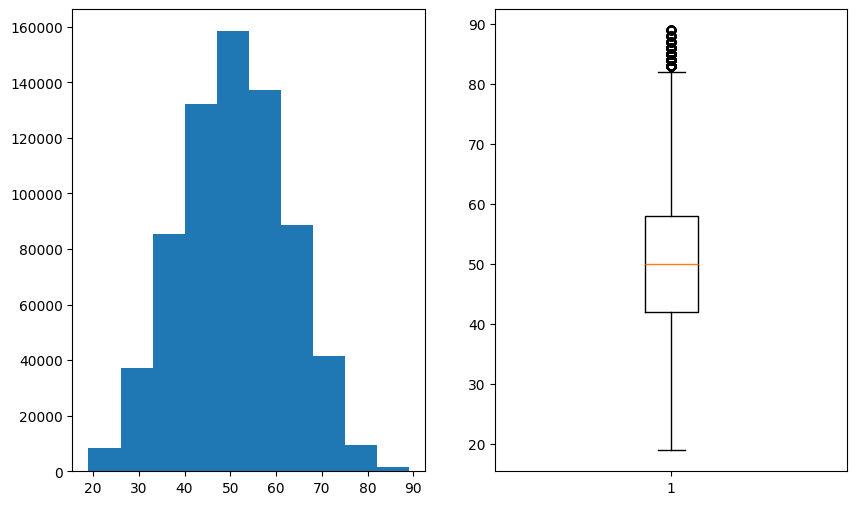

In [23]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(x=df_train["age"])
plt.subplot(1,2,2)
plt.boxplot(x=df_train["age"])
plt.show()

In [8]:
X = df_train
y = target

In [9]:
cat_cols = df_train[['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']].columns.tolist()
num_cols = [col for col in X.columns if col not in cat_cols]

In [10]:
preproccesing_tree = ColumnTransformer(transformers=[
    ('num_cols', 'passthrough', num_cols),
    ('cat_cols', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [11]:
pipe_tree = Pipeline(steps=[
    ('prep', preproccesing_tree),
    ('tree', DecisionTreeClassifier(random_state=42))
])

In [12]:
preproccesing_logreg = ColumnTransformer(transformers=[
    ('num_cols', StandardScaler(), num_cols),
    ('cat_cols', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [13]:
pipe_logreg = Pipeline(steps=[
    ('prep', preproccesing_logreg),
    ('logreg', LogisticRegression())
])

In [14]:
ensemble = VotingClassifier(estimators=[
    ('tree', pipe_tree),
    ('logreg', pipe_logreg)],
    voting='soft'
)

In [ ]:
for k in sorted(ensemble.get_params().keys()):
    if 'tree' in k or 'logreg' in k or 'max_depth' in k or 'C' in k:
        print(k)

In [ ]:
param_ensemble = {
    'tree__tree__max_depth': randint(5,25),
    'tree__tree__min_samples_split': randint(2,30),
    'tree__tree__min_samples_leaf': randint(1,30),
    'tree__tree__max_features': uniform(0.6, 0.4),
    'tree__tree__ccp_alpha': loguniform(1e-6, 1e-3),
    'logreg__logreg__C': loguniform(1e-2, 10),
    'logreg__logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'logreg__logreg__solver': ['lbfgs', 'liblinear', 'saga'],
    'logreg__logreg__max_iter': [1000, 2000, 3000, 4000, 5000]
}

rscv = RandomizedSearchCV(
    estimator=ensemble,
    param_distributions=param_ensemble,
    n_iter=55,
    scoring='roc_auc',
    cv=5,
    random_state=42, 
    n_jobs=-1
)

rscv.fit(X, y)

print(rscv.best_score_)
print(rscv.best_params_)

c:\Users\polis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
150 fits failed out of a total of 275.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\polis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\polis\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\polis\AppD

0.7024856376041246
{'logreg__logreg__C': np.float64(0.000914781098393379), 'logreg__logreg__max_iter': 2500, 'logreg__logreg__penalty': 'l2', 'logreg__logreg__solver': 'lbfgs', 'tree__tree__ccp_alpha': np.float64(9.415698826856012e-06), 'tree__tree__max_depth': 17, 'tree__tree__max_features': np.float64(0.9421842336044028), 'tree__tree__min_samples_leaf': 20, 'tree__tree__min_samples_split': 6}


In [16]:
best_ensemble_model = rscv.best_estimator_

In [27]:
pred = best_ensemble_model.predict_proba(df_test)[:,1]

In [28]:
submission = pd.DataFrame({
    "id": idk,
    "loan_paid_back": pred
})

In [29]:
submission.to_csv("P:/notebooks/competition KAGGLE/answer/Diabetes Prediction Challenge/submission.csv", index=False)